<h1><center> Домашняя работа #2</center></h1>

Задача:

- реализуйте алгоритм DQN с реплей буффером и мягким обновлением целевой сети;
- обучите агента в среде Lunar Lander;

Описание задачи на сайте Gymnasium ([ссылка](https://gymnasium.farama.org/environments/box2d/lunar_lander/))

## Imports

In [1]:
!nvidia-smi

Tue Nov 25 22:49:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import sys

sys.path.append("..")

In [2]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from tqdm import trange

In [3]:
from src.deep_q_learning import (
    DQN,
    ReplayMemory,
    select_action,
    optimize_model,
    soft_update,
)
from src.torch_utils import get_device

## Environment

**Observation space:**

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Actions:**

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

**Rewards:**

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

**Note** `pip install "gymnasium[box2d]"` fails horribly. Install `swig` and then `Box2D`. It's also in requirements

Source [Git](https://github.com/Farama-Foundation/Gymnasium/issues/1324#issuecomment-2700987713)

In [5]:
# %pip install swig

In [6]:
# %pip install Box2D

In [7]:
env = gym.make(
    "LunarLander-v3",
    continuous=False,  # Для DQN нужен дискретный набор действий
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    max_episode_steps=1_000,
    # render_mode="human"  # Раскомментируйте, чтобы увидеть игру
)

## Model

Вспомним, что в "классическом" Q-learning мы обновляем q-значения (награды) на сетке следующим образом:

$$\begin{align*}
Q(s, a) &\leftarrow Q(s, a) + \alpha \delta \\
\text{where } \delta &= R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a) \\
\\
\text{and } & s \text{ - current state} \\
& a \text{ - current action} \\
& s' \text{ - next state} \\
& \alpha \text{ - learning rate } (0 \leq \alpha \leq 1) \\
& \gamma \text{ - discount factor } (0 \leq \gamma \leq 1) \\
& R(s, a) \text{ - immediate reward}
\end{align*}$$

$\delta$ также известна temporal diffrence error.

В Deep Q-learning (DQM) мы хотим обучить нейронную сеть для прогноза $Q^*$ путем минимазации $\delta$

Для этого нам нужно реализовать в PyTorch следующее:

1. Replay Buffer or Replay Memory - "хранилище" векторов $(s_j, a_j, r_j, s_j')$
2. Policy Network or Online Network - модель, которую DQN агент использует на каждом шаге для прогноза Q-значений и выбора действия (вместо выбора максимального значения как раньше).
3. Target network - более стабильная онлайн модель, которая используется для прогноза ожидаемых Q-значений



Источники:
- ["Reinforcement Learning (DQN) Tutorial"](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- ["Глубокое Q-обучение (DQN)"](https://habr.com/ru/articles/906594/)

In [8]:
device = get_device()

In [9]:
device

device(type='cuda')

In [10]:
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

In [11]:
# Основные параметры RL
gamma = torch.tensor(0.99).to(device)  # discount_factor
epsilon = 0.9  # probability of random action
epsilon_decay = 0.001  # eps_t = eps_t-1 * (1 - epsilon_decay)

# Основные параметры DL
lr = 1e-4
tau = 0.005
exploratory_period = 2_000
n_epochs = 3_000
batch_size = 256

In [12]:
policy_net = DQN(n_observations, n_actions).to(device)

target_net = DQN(n_observations, n_actions).to(device)
# Policy weight sets have to be the same
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [13]:
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr, fused=True)

In [14]:
replay_memory = ReplayMemory(capacity=10_000, batch_size=batch_size)

In [15]:
assert len(replay_memory.memory) == 0

In [16]:
rewards = []

for num_episode in trange(n_epochs):

    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)

    exploratory_period_flag = num_episode < exploratory_period

    if num_episode == exploratory_period:
        print("Finished exploration. Starting to train model")

    done = False
    next_state = None
    total_reward = 0
    steps = 0

    while not done:

        action = select_action(
            n_actions=n_actions,
            epsilon=epsilon,
            state=state,
            policy_net=policy_net,
            exploratory_period=exploratory_period_flag,
            device=device,
        )

        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        # Perform one step of the optimization (on the policy network)
        if not exploratory_period_flag:
            optimize_model(
                optimizer=optimizer,
                device=device,
                criterion=torch.nn.SmoothL1Loss(),
                train_sample=replay_memory.sample(),
                policy_net=policy_net,
                target_net=target_net,
                gamma=gamma,
                verbose=((num_episode % 100 == 0) & done),
            )

        reward = torch.tensor([reward], device=device)
        done_mask = torch.tensor([terminated], device=device).to(torch.float32)
        next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        replay_memory.push(state, action, next_state, reward, done_mask)

        state = next_state
        total_reward += reward
        steps += 1

    rewards.append((steps, total_reward))

    # Using soft updates to update target policy
    # Hard updates would mean completely re-defining weights every n steps
    soft_update(target_net=target_net, policy_net=policy_net, tau=tau)

    if not exploratory_period_flag:
        epsilon *= 1 - epsilon_decay
        if num_episode % 100 == 0:
            print(f"Total reward: {total_reward.item()}")

 67%|██████▋   | 1997/3000 [01:01<00:26, 37.71it/s]

Finished exploration. Starting to train model


 67%|██████▋   | 2001/3000 [01:02<01:23, 11.97it/s]

Loss function value: 2.4256592731557123
Total reward: -386.06038855668186


 70%|███████   | 2101/3000 [02:07<09:13,  1.63it/s]

Loss function value: 1.4315701673625834
Total reward: -15.477945942849203


 73%|███████▎  | 2201/3000 [03:12<08:14,  1.62it/s]

Loss function value: 0.40429340949737785
Total reward: -147.14485987881338


 77%|███████▋  | 2301/3000 [04:26<09:11,  1.27it/s]

Loss function value: 1.4560264880103477
Total reward: -112.37405953229757


 80%|████████  | 2401/3000 [05:56<08:22,  1.19it/s]

Loss function value: 2.143657238840505
Total reward: -17.668717648081213


 83%|████████▎ | 2501/3000 [07:37<12:20,  1.48s/it]

Loss function value: 0.9417282652069117
Total reward: -85.19596172680912


 87%|████████▋ | 2601/3000 [09:41<06:59,  1.05s/it]

Loss function value: 1.3621988120899795
Total reward: -28.128219684045362


 90%|█████████ | 2701/3000 [12:14<06:06,  1.23s/it]

Loss function value: 1.0738477598500369
Total reward: -33.465662358940364


 93%|█████████▎| 2801/3000 [14:54<07:15,  2.19s/it]

Loss function value: 0.8396931547742297
Total reward: 78.4185409591934


 97%|█████████▋| 2901/3000 [17:55<02:58,  1.80s/it]

Loss function value: 1.0003956825381997
Total reward: 0.14489759372187905


100%|██████████| 3000/3000 [21:47<00:00,  2.29it/s]


In [17]:
torch.save(policy_net.state_dict(), "hw_2_trained_agent.pickle")

## Training graphs

In [19]:
table = pd.DataFrame(rewards, columns=["steps", "reward"])
# table = table.iloc[2_000:, :]  # remove exploratory_period

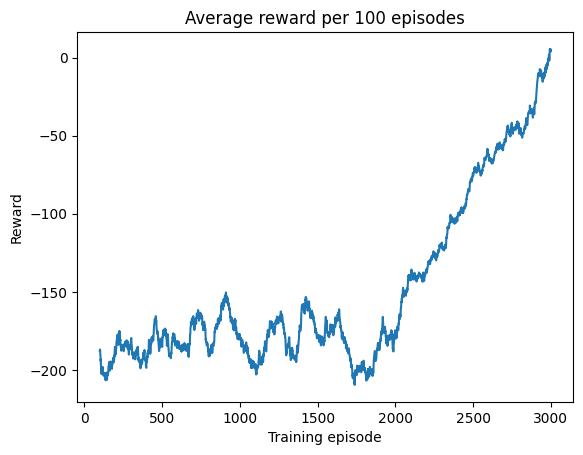

In [20]:
plt.plot(table.index, table["reward"].rolling(100).mean())
plt.xlabel("Training episode")
plt.ylabel("Reward")
plt.title("Average reward per 100 episodes")
plt.show()

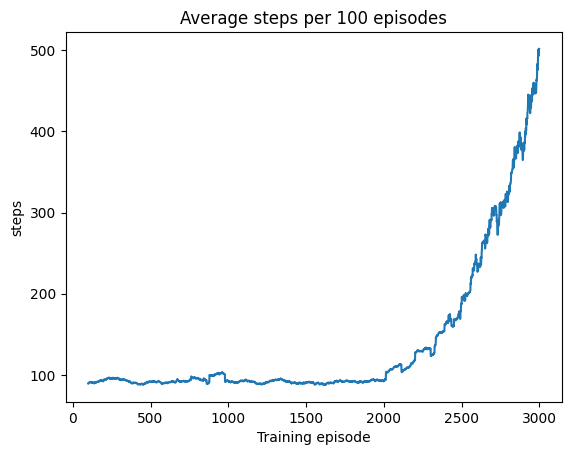

In [21]:
plt.plot(table.index, table["steps"].rolling(100).mean())
plt.xlabel("Training episode")
plt.ylabel("steps")
plt.title("Average steps per 100 episodes")
plt.show()

## Анимация

In [9]:
env = gym.make(
    "LunarLander-v3",
    continuous=False,  # Для DQN нужен дискретный набор действий
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    max_episode_steps=1_000,
    render_mode="human",  # Раскомментируйте, чтобы увидеть игру
)

In [10]:
device = get_device()

done = False
score = 0
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device)
n_actions = env.action_space.n
n_observations = len(state)

policy_net_2 = DQN(n_observations, n_actions).to(device)
policy_net_2.load_state_dict(
    torch.load("hw_2_trained_agent.pickle", map_location=device)
)

while not done:
    env.render()  # Раскомментируйте, чтобы увидеть игру
    with torch.no_grad():
        # best action
        action = policy_net_2(state).argmax()
    next_state, reward, terminated, truncated, info = env.step(action.item())
    done = terminated or truncated
    state = next_state
    state = torch.tensor(state, dtype=torch.float32, device=device)
    score += reward

env.close()

print(f"Score is: {score}")

Используемое устройство: cpu
Score is: -97.30140652508848
